In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from Generator import Generator

## Parameters

#### Data Generation

In [2]:
low = 0.1                                    #
high = 5                                     #
rank = True                                  #

train_examples = 1000
test_examples = 100

#### Model

In [3]:
embed_dim = 512                              #
stack = 8                                    #

optimizer = keras.optimizers.Nadam()         #
loss = keras.losses.MSE                      # Regression Loss Function


metrics = keras.metrics.MeanSquaredError()

2022-04-05 20:31:35.217672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-05 20:31:35.241500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-05 20:31:35.241923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-05 20:31:35.243037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

#### Training

In [4]:
batch_size = 128
epochs = 10

validation_split = 0.2
verbose = 2

## Generate Data

In [5]:
generator = Generator('nutrients.csv') # filename with data

In [6]:
generator.generate(train_examples) # generates arg number of examples
generator.scale(low,high) # scales ingredients individually between min and max arg values
if rank == True:
    generator.rank()

recipes = generator.recipes # recipes
quant = generator.quant # quantity of ingredients

## Build Model

In [7]:
embed_dim = embed_dim
stack = stack
i1 = keras.layers.Input(recipes.shape[1:])
f1 = keras.layers.Flatten()(i1)
y1 = keras.layers.Dense(embed_dim)(f1)

# Stack residual blocks (skip connections)
for _ in range(stack):
    y2 = y1
    y1 = keras.layers.Dense(embed_dim,
        activation=keras.activations.relu)(y1)
    y1 = keras.layers.Add()([y1,y2])
    y1 = keras.layers.LayerNormalization()(y1)

o1 = keras.layers.Dense(recipes.shape[1])(y1)
    
model = keras.Model(i1,o1)

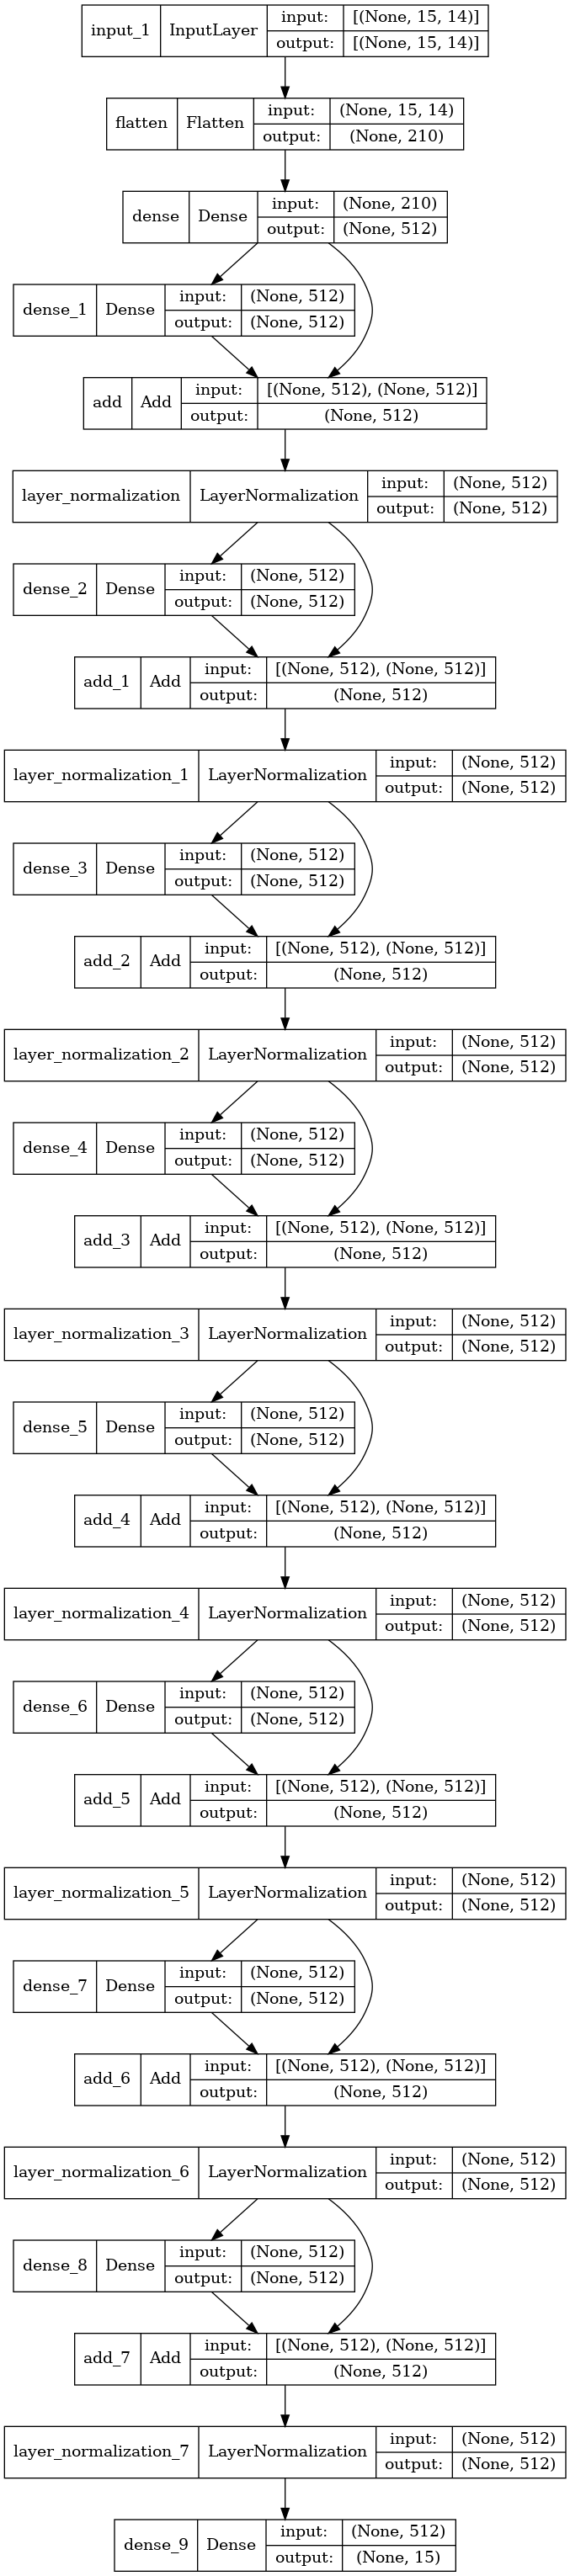

In [8]:
keras.utils.plot_model(model,to_file='recipe_model.png',show_shapes=True,expand_nested=True)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 14)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 210)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 512)          108032      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          262656      ['dense[0][0]']                  
                                                                                              

In [10]:
model.compile(optimizer=optimizer,
            loss=loss,
            metrics=metrics)

## Train

In [11]:
history = model.fit(
    recipes, quant, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split = validation_split, 
    verbose=verbose
)

Epoch 1/10


2022-04-05 20:31:45.463104: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-05 20:31:45.640504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


7/7 - 4s - loss: 3.6212 - mean_squared_error: 3.6212 - val_loss: 1.6236 - val_mean_squared_error: 1.6236 - 4s/epoch - 590ms/step
Epoch 2/10
7/7 - 0s - loss: 1.4984 - mean_squared_error: 1.4984 - val_loss: 1.2543 - val_mean_squared_error: 1.2543 - 105ms/epoch - 15ms/step
Epoch 3/10
7/7 - 0s - loss: 0.9243 - mean_squared_error: 0.9243 - val_loss: 1.0248 - val_mean_squared_error: 1.0248 - 106ms/epoch - 15ms/step
Epoch 4/10
7/7 - 0s - loss: 0.6919 - mean_squared_error: 0.6919 - val_loss: 1.0247 - val_mean_squared_error: 1.0247 - 114ms/epoch - 16ms/step
Epoch 5/10
7/7 - 0s - loss: 0.6783 - mean_squared_error: 0.6783 - val_loss: 0.8561 - val_mean_squared_error: 0.8561 - 107ms/epoch - 15ms/step
Epoch 6/10
7/7 - 0s - loss: 0.5609 - mean_squared_error: 0.5609 - val_loss: 0.8515 - val_mean_squared_error: 0.8515 - 116ms/epoch - 17ms/step
Epoch 7/10
7/7 - 0s - loss: 0.5268 - mean_squared_error: 0.5268 - val_loss: 1.0558 - val_mean_squared_error: 1.0558 - 117ms/epoch - 17ms/step
Epoch 8/10
7/7 - 0s

## Testing

In [12]:
#prediction values
test_gen = Generator('nutrients.csv')
test_gen.generate(test_examples) # generates arg number of examples
test_gen.scale(low,high) # scales ingredients individually between min and max arg values

if rank == True:
    test_gen.rank()

In [13]:
test_recipes = test_gen.recipes
test_quant = test_gen.quant

In [14]:
score = model.evaluate(test_recipes, test_quant, verbose=1)

4/4 [==============================] - 0s 4ms/step - loss: 0.7555 - mean_squared_error: 0.7555


In [15]:
model.predict(test_recipes[0:1])

array([[ 0.3342672 ,  2.6424825 ,  2.5414162 , -0.2515976 ,  0.02216654,
        -0.12150389,  4.385798  ,  2.3961892 ,  3.8484542 ,  1.0492364 ,
        -0.13102734, -1.2263999 ,  2.6547542 , -0.15764198,  1.8658321 ]],
      dtype=float32)